In [40]:
import numpy as np
import scipy.fft as fft
import scipy.signal as signal
from scipy.linalg import norm 
from scipy.signal import TransferFunction as tf
import matplotlib.pyplot as plt
%matplotlib inline

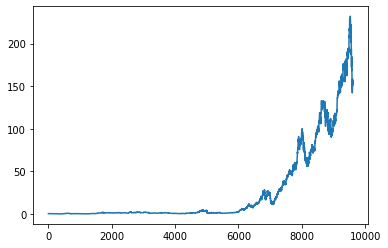

In [41]:
import csv
stock_dates = []
stock_prices  = []
with open('AAPL.csv', mode='r') as raw_data:
    csv_reader = csv.DictReader(raw_data)
    for row in csv_reader:
        data = row['Close']
        if not data == 'null':
            stock_prices.append(float(data))
            stock_dates.append(row['Date'])
stock_prices = np.array(stock_prices)

# 400 most recent days
start = -400
end = -1
raw_data = stock_prices #[start:end]
data = raw_data
plt.plot(data)

In [42]:

#finds the frequency band that contains the given energy
def band(Exx, energy, N):

    e = 0.0
    m = round(len(Exx)/2)
    w = m

    while e < energy:     
        e += 2*Exx[w]
        w += 1
        if (w >= len(Exx)-1):
            break
    return w

0.03764


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


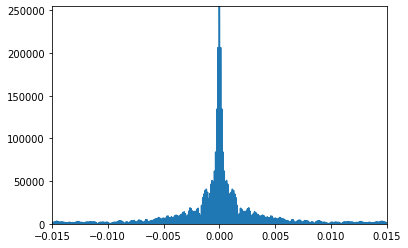

In [43]:
Ep = 1.01 #percent energy band
fft_len = 200000 
data_fft = fft.fftshift(fft.fft(data, fft_len))
data_freq = fft.fftshift(fft.fftfreq(fft_len))

N = len(data_freq)
Exx_data = abs(data)**2
Exx_fft = (abs(data_fft)**2)/N
energy = sum(Exx_data)

energy = Ep*energy
b = data_freq[band(Exx_fft, energy, N)]

#"""
B = 0.01
plt.figure()
plt.axis([-B*1.5,B*1.5,0,max(data_fft)])
plt.plot(data_freq, data_fft)
plt.axvline(b, color='green') # cutoff frequency
plt.axvline(data_freq[round(len(data_freq)/2)]-b, color='green') # cutoff frequency
#"""

"""
plt.figure()
f, Pxx_spec = signal.welch(data)
plt.plot(f, Pxx_spec)
"""

print(b)


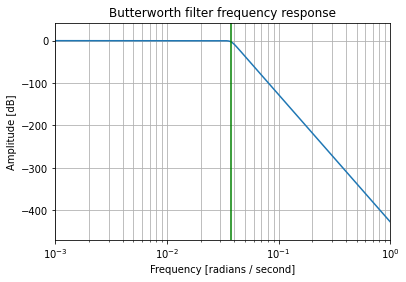

In [44]:
N = 15
W = b
b, a = signal.butter(N, W, 'low', 'ba')
w, h = signal.freqs(b, a, fft_len)

plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(W, color='green') # cutoff frequency
plt.show()



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


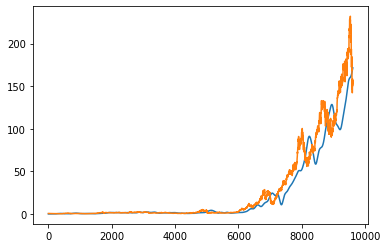

In [45]:
sys = tf(b, a)
T = np.array([i for i in range(len(data))])
tout, yout, xout = signal.lsim(sys, data, T)
plt.plot(tout, yout)
plt.plot(data)

MA length for 101.0%: 74


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/signal/_filter_design.py:474: RuntimeWarning: invalid value encountered in true_divide
  h = (npp_polyval(zm1, b, tensor=False) /
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


"\nplt.semilogx(w, 20 * np.log10(abs(h)))\nplt.title('{} SMA filter frequency response'.format(L))\nplt.xlabel('Frequency [radians / second]')\nplt.ylabel('Amplitude [dB]')\n#plt.margins(0, 0.1)\nplt.grid(which='both', axis='both')\nplt.axvline(W, color='green') # cutoff frequency\nplt.show()\n"

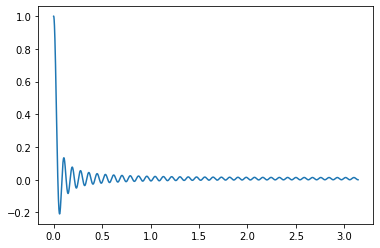

In [46]:
L = round(np.sqrt(0.196202+(W/(2*np.pi))**2)/(W/(2*np.pi)))
print("MA length for {}%: {}".format(Ep*100, L))

num = np.array([0 for i in range(L+1)])
num[0] = 1
num[len(num)-1] = -1
den = np.array([1,-1])*L

w, h = signal.freqz(num, den, worN=fft_len)

plt.plot(w,h)

"""
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('{} SMA filter frequency response'.format(L))
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
#plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(W, color='green') # cutoff frequency
plt.show()
"""

In [47]:
"""
sys = signal.TransferFunction(num, den)
T, yout, xout = signal.lsim(sys, data, np.arange(len(data)))
plt.plot(T, yout)
"""

'\nsys = signal.TransferFunction(num, den)\nT, yout, xout = signal.lsim(sys, data, np.arange(len(data)))\nplt.plot(T, yout)\n'